**Carregando Dados** 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#carregar dados
train = pd.read_csv('./data/train.csv', parse_dates=['date'])
test = pd.read_csv('./data/test.csv', parse_dates=['date'])
stores = pd.read_csv('./data/stores.csv')
oil = pd.read_csv('./data/oil.csv', parse_dates=['date'])
holidays = pd.read_csv('./data/holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv('./data/transactions.csv', parse_dates=['date'])

#tirando dados de antes de 2013
train = train[train['date'] > '2013-01-01']

In [2]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
1782,1782,2013-01-02,1,AUTOMOTIVE,2.0,0
1783,1783,2013-01-02,1,BABY CARE,0.0,0
1784,1784,2013-01-02,1,BEAUTY,2.0,0
1785,1785,2013-01-02,1,BEVERAGES,1091.0,0
1786,1786,2013-01-02,1,BOOKS,0.0,0


**Modificando Date**

In [3]:
# Quebrando data em dia mes ano
def add_date_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)
    return df


train = add_date_features(train)
test = add_date_features(test)

train.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,weekday,is_weekend
1782,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,2013,1,2,2,0
1783,1783,2013-01-02,1,BABY CARE,0.0,0,2013,1,2,2,0
1784,1784,2013-01-02,1,BEAUTY,2.0,0,2013,1,2,2,0
1785,1785,2013-01-02,1,BEVERAGES,1091.0,0,2013,1,2,2,0
1786,1786,2013-01-02,1,BOOKS,0.0,0,2013,1,2,2,0


In [4]:
#adicionando coluna is_holiday no dataset
valid_holidays = holidays[holidays['transferred'] == False].copy()
valid_holidays['is_holiday'] = 1
valid_holidays = valid_holidays[['date', 'is_holiday']]
train = train.merge(valid_holidays, on='date', how='left').fillna({'is_holiday': 0}).astype({'is_holiday': 'int'})
test = test.merge(valid_holidays, on='date', how='left').fillna({'is_holiday': 0}).astype({'is_holiday': 'int'})

train.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,weekday,is_weekend,is_holiday
0,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,2013,1,2,2,0,0
1,1783,2013-01-02,1,BABY CARE,0.0,0,2013,1,2,2,0,0
2,1784,2013-01-02,1,BEAUTY,2.0,0,2013,1,2,2,0,0
3,1785,2013-01-02,1,BEVERAGES,1091.0,0,2013,1,2,2,0,0
4,1786,2013-01-02,1,BOOKS,0.0,0,2013,1,2,2,0,0


**Outros merges e modificacoes**

In [5]:
#merge oil
oil.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)
train = train.merge(oil[['date', 'oil_price']], on='date', how='left')
test = test.merge(oil[['date', 'oil_price']], on='date', how='left')



#merge store
train = train.merge(stores, on='store_nbr', how='left')
test = test.merge(stores, on='store_nbr', how='left')

#merge transaction
train = train.merge(transactions, on=["date", "store_nbr"], how='left')
test = test.merge(transactions, on=["date", "store_nbr"], how='left')

#tirar NAN do oilprice
for df in [train, test]:
    df['oil_price'] = df['oil_price'].ffill().bfill()

#onpromotion 0 | 1
train['onpromotion'] = np.where(train['onpromotion'] == 0.0, 0, 1)
test['onpromotion'] = np.where(test['onpromotion'] == 0.0, 0, 1)


#nao vou usar localizaçao por enqnt
train = train.drop(['city', 'state', 'type', 'date', 'id'], axis=1)
test = test.drop(['city', 'state', 'type', 'date'], axis=1)

train.head()

,store_nbr,family,sales,onpromotion,year,month,day,weekday,is_weekend,is_holiday,oil_price,cluster,transactions
0,1,AUTOMOTIVE,2.0,0,2013,1,2,2,0,0,93.14,13,2111.0
1,1,BABY CARE,0.0,0,2013,1,2,2,0,0,93.14,13,2111.0
2,1,BEAUTY,2.0,0,2013,1,2,2,0,0,93.14,13,2111.0
3,1,BEVERAGES,1091.0,0,2013,1,2,2,0,0,93.14,13,2111.0
4,1,BOOKS,0.0,0,2013,1,2,2,0,0,93.14,13,2111.0


**Analise de dados**

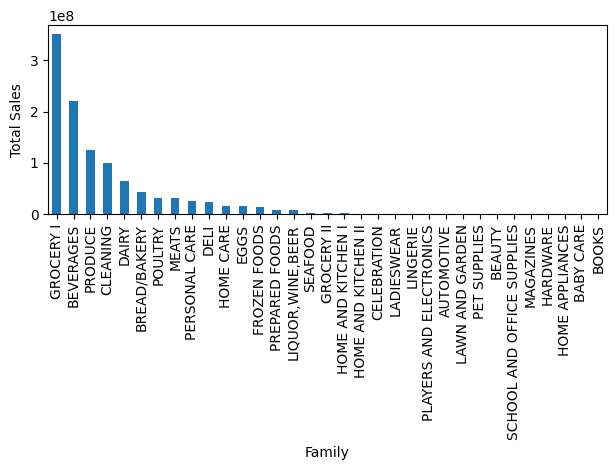

In [6]:
def plot_family_frequency(df):
    sales_sum = df.groupby('family')['sales'].sum().sort_values(ascending=False)
    
    plt.figure()
    sales_sum.plot(kind='bar')
    plt.xlabel('Family')
    plt.ylabel('Total Sales')
    plt.tight_layout()
    plt.show()

plot_family_frequency(train)

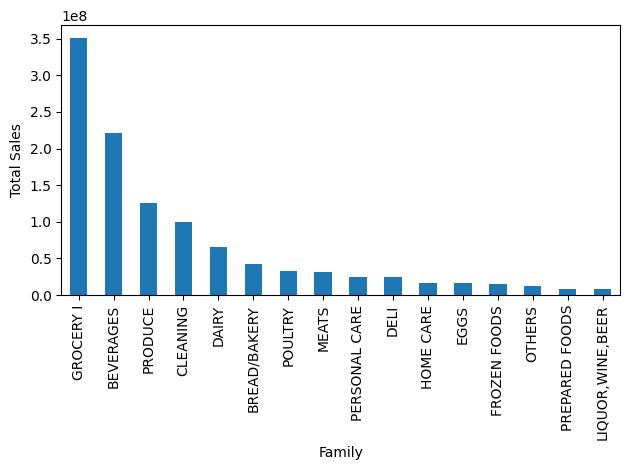

In [7]:
# Transforma as menos comuns em others.

sales_sum = train.groupby('family')['sales'].sum()
    
n_families = len(sales_sum)


low_fams = sales_sum.nsmallest(18).index.tolist()

train['family'] = train['family'].apply(lambda x: 'OTHERS' if x in low_fams else x)
test['family'] = test['family'].apply(lambda x: 'OTHERS' if x in low_fams else x)


plot_family_frequency(train)

In [8]:
#encoding
family_encoding1 = pd.get_dummies(train['family'], prefix='family').astype(int)
train = pd.concat([train, family_encoding1], axis=1)

family_encoding2 = pd.get_dummies(test['family'], prefix='family').astype(int)
test = pd.concat([test, family_encoding2], axis=1)


train.head()

,store_nbr,family,sales,onpromotion,year,month,day,weekday,is_weekend,is_holiday,...,family_FROZEN FOODS,family_GROCERY I,family_HOME CARE,"family_LIQUOR,WINE,BEER",family_MEATS,family_OTHERS,family_PERSONAL CARE,family_POULTRY,family_PREPARED FOODS,family_PRODUCE
0,1,OTHERS,2.0,0,2013,1,2,2,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,OTHERS,0.0,0,2013,1,2,2,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,OTHERS,2.0,0,2013,1,2,2,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,BEVERAGES,1091.0,0,2013,1,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,OTHERS,0.0,0,2013,1,2,2,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
#concatena train e test
train['is_train'] = 1
test ['is_train'] = 0
test ['sales'] = np.nan
full = pd.concat([train, test], sort=False)

#ordena por serie e data
full = full.sort_values(['store_nbr','family'] + ['year','month','day'])

#lags 
for lag in [1, 7, 14, 28]:
    full[f'sales_lag_{lag}'] = (
        full.groupby(['store_nbr','family'])['sales']
            .shift(lag)
    )

#rolling windows
for window in [7,14,30]:
    grp = full.groupby(['store_nbr','family'])['sales']
    full[f'sales_rollmean_{window}'] = (
        grp.shift(1).rolling(window).mean().reset_index(0,drop=True)
    )
    full[f'sales_rollstd_{window}'] = (
        grp.shift(1).rolling(window).std().reset_index(0,drop=True)
    )

#volta ao normal
train_fe = full[full['is_train']==1].drop(['is_train'], axis=1)
test_fe  = full[full['is_train']==0].drop(['is_train','sales'], axis=1)

train_fe = train_fe.drop(['family'], axis=1)
test_fe = test_fe.drop(['family'], axis=1)

In [10]:
y_train = train_fe['sales']
X_train = train_fe.drop(['sales'], axis=1)
test  = test_fe.drop('id',     axis=1)

# replace becuae xgboost doesnt work when headers have " "
X_train.columns = [col.replace(" ", "_").replace("-", "_") for col in X_train.columns]
test.columns = [col.replace(" ", "_").replace("-", "_") for col in test.columns]

train_fe.head()

,store_nbr,sales,onpromotion,year,month,day,weekday,is_weekend,is_holiday,oil_price,...,sales_lag_1,sales_lag_7,sales_lag_14,sales_lag_28,sales_rollmean_7,sales_rollstd_7,sales_rollmean_14,sales_rollstd_14,sales_rollmean_30,sales_rollstd_30
3,1,1091.0,0,2013,1,2,2,0,0,93.14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1785,1,919.0,0,2013,1,3,3,0,0,92.97,...,1091.0,NaN,NaN,NaN,291.006003,69.792116,289.723144,68.644061,260.804234,84.246536
3567,1,953.0,0,2013,1,4,4,0,0,93.12,...,919.0,NaN,NaN,NaN,597.000000,171.722645,598.071429,193.938715,594.200000,217.193129
5349,1,1160.0,0,2013,1,5,5,1,1,93.12,...,953.0,NaN,NaN,NaN,417.714286,110.119199,411.214286,113.035854,396.033333,112.558179
7131,1,407.0,0,2013,1,6,6,1,0,93.12,...,1160.0,NaN,NaN,NaN,102.849143,31.319146,97.689143,30.089814,99.602100,28.965437


In [11]:
#X_train['family']

**Model**

In [12]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error


def clean_feature_names(df):
    df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)
    return df

X_train = clean_feature_names(X_train)
test    = clean_feature_names(test)


y_train_log = np.log1p(y_train)

#separa 10% para validação
x_tr, x_val, y_tr, y_val = train_test_split(
    X_train, y_train_log,
    test_size=0.10,
    random_state=42
)

#datasets
lgb_train = lgb.Dataset(x_tr, label=y_tr)
lgb_val   = lgb.Dataset(x_val, label=y_val, reference=lgb_train)


params = {
    'objective': 'regression',
    'metric': 'rmse',           
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42,
    'verbose': -1
}

In [13]:
evals_result = {}
model = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.05,
    num_leaves=31,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    n_estimators=2000,
    random_state=42,
    verbose=-1
)

model.fit(
    x_tr, y_tr,
    eval_set=[(x_tr, y_tr), (x_val, y_val)],
    eval_metric='rmse',
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(period=100)
    ]
)


y_val_pred_log = model.predict(x_val, num_iteration=model.best_iteration_)
y_val_pred = np.expm1(y_val_pred_log)
y_val_true = np.expm1(y_val)

y_val_pred = np.clip(y_val_pred, 0, None)
y_val_true = np.clip(y_val_true, 0, None)

rmsle = np.sqrt(mean_squared_log_error(y_val_true, y_val_pred))
print(f'Val RMSLE: {rmsle:.5f}')

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.749882	training's l2: 0.562322	valid_1's rmse: 0.750614	valid_1's l2: 0.563422
[200]	training's rmse: 0.711664	training's l2: 0.506466	valid_1's rmse: 0.712849	valid_1's l2: 0.508153
[300]	training's rmse: 0.69069	training's l2: 0.477053	valid_1's rmse: 0.692023	valid_1's l2: 0.478896
[400]	training's rmse: 0.677414	training's l2: 0.458889	valid_1's rmse: 0.678809	valid_1's l2: 0.460781
[500]	training's rmse: 0.668116	training's l2: 0.446379	valid_1's rmse: 0.669751	valid_1's l2: 0.448566
[600]	training's rmse: 0.660553	training's l2: 0.43633	valid_1's rmse: 0.6624	valid_1's l2: 0.438774
[700]	training's rmse: 0.654788	training's l2: 0.428747	valid_1's rmse: 0.656774	valid_1's l2: 0.431352
[800]	training's rmse: 0.649979	training's l2: 0.422472	valid_1's rmse: 0.652228	valid_1's l2: 0.425402
[900]	training's rmse: 0.645358	training's l2: 0.416486	valid_1's rmse: 0.647858	valid_1's l2: 0.41972
[1000]	

**Submission**

In [14]:
# test_pred_log = model.predict(test.drop(columns=['id']), num_iteration=model.best_iteration_)
# test_pred = np.expm1(test_pred_log)
# test_pred[test_pred < 0] = 0 

# submission = pd.DataFrame({
#     'id': test['id'],
#     'sales': test_pred
# })

# submission.to_csv('submission.csv', index=False)